#  **Basic Setup installing libraries& getting the data**

In [1]:
!pip install torch torchvision matplotlib tqdm pillow==11.0.0 -qU

In [2]:
!git clone https://github.com/EyadAlN3imi/DS372-Forensics.git

fatal: destination path 'DS372-Forensics' already exists and is not an empty directory.


In [75]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torchvision import transforms
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway
from PIL import Image, ImageOps
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = "/content/DS372-Forensics/Datasets/BPA_DATA"
os.listdir(data_path)

['FINAL_ALL_DATA.csv', 'FINAL_ALL_IMAGES']

# **1.The Global View**
1.1. Basic Setup – Load Images + CSV

In [5]:
df = pd.read_csv('/content/DS372-Forensics/Datasets/BPA_DATA/FINAL_ALL_DATA.csv')
df

,image_name,class,source_dataset
0,C1_beat.jpg,beating,beating
1,C10_beat.jpg,beating,beating
2,C11_beat.jpg,beating,beating
3,C12_beat.jpg,beating,beating
4,C2_beat.jpg,beating,beating
...,...,...,...
326,9-675.jpg,blood drip,paper75
327,9-775.jpg,blood drip,paper75
328,9-875.jpg,blood drip,paper75
329,9-975.jpg,blood drip,paper75


In [6]:
img_dir = os.path.join(data_path, "FINAL_ALL_IMAGES")
total_size_bytes = 0
for img_name in df['image_name']:
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        total_size_bytes += os.path.getsize(img_path)

total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total images storage size: {total_size_mb:.2f} MB")

Total images storage size: 16.55 MB


1.2. Basic Info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_name      331 non-null    object
 1   class           331 non-null    object
 2   source_dataset  331 non-null    object
dtypes: object(3)
memory usage: 7.9+ KB


1.3. Frequency Table + Percent + Cumulative Percent

In [8]:
freq_table = pd.DataFrame({
    'Count': df['class'].value_counts(),
    'Percentage': df['class'].value_counts(normalize=True) * 100
})

freq_table['Cumulative %'] = freq_table['Percentage'][::-1].cumsum()[::-1].round(2)
freq_table['Percentage'] = freq_table['Percentage'].round(2)

freq_table

,Count,Percentage,Cumulative %
class,,,
blood drip,202,61.03,100.00
gun shot,68,20.54,38.97
beating,61,18.43,18.43


1.4. show the class distribution  

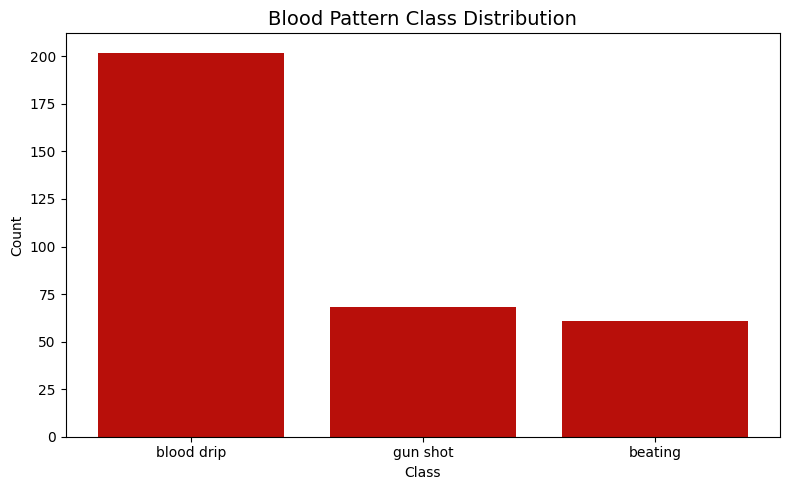

In [9]:
counts = df['class'].value_counts()

plt.figure(figsize=(8, 5))

plt.bar(counts.index, counts.values, color="#B80F0A")

plt.title("Blood Pattern Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()

plt.show()

1.5. Show Random Samples Per Class

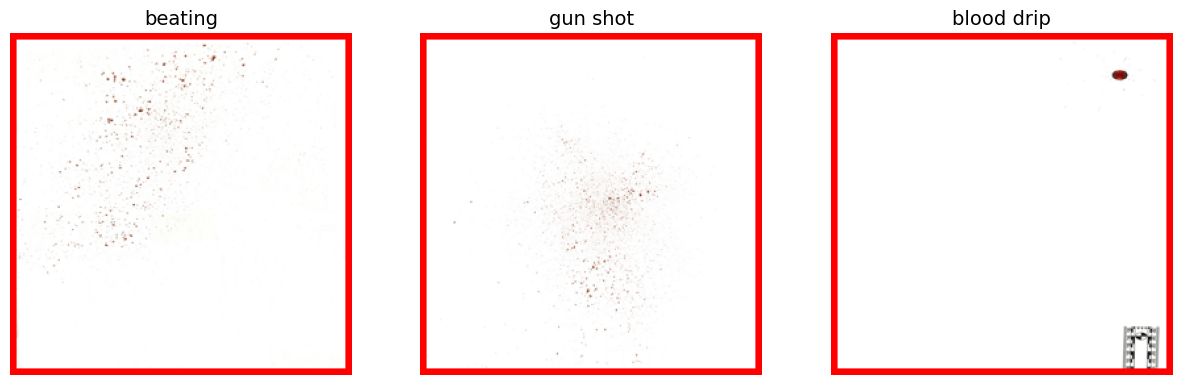

In [10]:
img_dir = os.path.join(data_path, "FINAL_ALL_IMAGES")

classes = df['class'].unique()

fig, ax = plt.subplots(1, len(classes), figsize=(5 * len(classes), 6))

for i, cls in enumerate(classes):
    subset = df[df['class'] == cls]
    img_name = subset.sample(1)['image_name'].values[0]
    path = os.path.join(img_dir, img_name)

    img = Image.open(path).resize((250, 250))

    img = ImageOps.expand(img, border=5, fill="red")

    ax[i].imshow(img)
    ax[i].set_title(cls, fontsize=14)
    ax[i].axis("off")

plt.subplots_adjust(wspace=0.2)
plt.show()


# Embedding Extraction & Dimensionality Reduction

1.6. Loading embeddings model

In [11]:
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def get_dino_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        emb = dino_model(img)
    return emb.cpu().numpy().flatten()

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 235MB/s]


1.7. Extract embeddings

In [12]:
embeddings = []
labels = []

print(f"Processing {len(df)} images...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(img_dir, row['image_name'])
    label = row['class']

    emb = get_dino_embedding(img_path)
    embeddings.append(emb)
    labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(labels)

print(f"\nEmbeddings extracted")
print(f"  - Shape: {embeddings.shape}")
print(f"  - Embedding dimension: {embeddings.shape[1]}")

Processing 331 images...


100%|██████████| 331/331 [01:37<00:00,  3.39it/s]


Embeddings extracted
  - Shape: (331, 384)
  - Embedding dimension: 384


1.8. Normalize the embeddings

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

print(f"✓ Features normalized")
print(f"  - Shape: {X_scaled.shape}")
print(f"  - Mean: {X_scaled.mean(axis=0)[:5]}...")
print(f"  - Std: {X_scaled.std(axis=0)[:5]}...")

✓ Features normalized
  - Shape: (331, 384)
  - Mean: [ 3.2413403e-09 -3.1513029e-08  8.9677080e-08 -2.3330896e-08
  1.1668825e-07]...
  - Std: [1.         1.0000001  1.0000001  0.99999976 1.0000001 ]...


1.9. t-SNE to 3D

In [14]:
tsne = TSNE(
    n_components=3,
    learning_rate='auto',
    init='pca',
    perplexity=15,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

print(f"t-SNE - Shape: {X_tsne.shape}")

t-SNE - Shape: (331, 3)


1.10. 3D Scatter Plots

In [30]:
# --- GLOBAL COLOR CONFIGURATION ---
# Define a fixed color map based on sorted class names to ensure consistency
unique_classes = sorted(df['class'].unique())

# Define your preferred colors (Plotly default hex codes used here for quality)
# You can change these hex codes to any specific colors you want.
palette = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

class_colors = {cls: palette[i % len(palette)] for i, cls in enumerate(unique_classes)}

print("Global Color Map Assigned:")
for cls, color in class_colors.items():
    print(f"  {cls}: {color}")

Global Color Map Assigned:
  beating: #636EFA
  blood drip: #EF553B
  gun shot: #00CC96


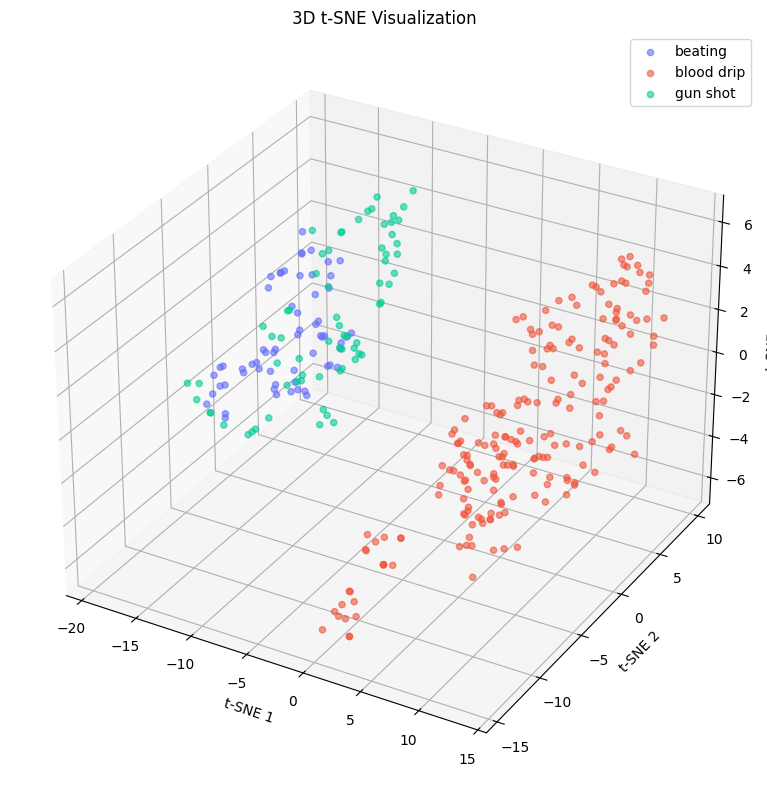

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2],
               c=class_colors[label],
               label=label,
               s=20,
               alpha=0.6)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.set_title('3D t-SNE Visualization')
ax.legend()

plt.tight_layout()
plt.show()

In [32]:
fig = px.scatter_3d(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    z=X_tsne[:, 2],
    color=labels,
    title="3D t-SNE Visualization",
    labels={
        "x": "t-SNE 1",
        "y": "t-SNE 2",
        "z": "t-SNE 3",
        "color": "Class"
    },
    color_discrete_map=class_colors
)

fig.update_traces(marker=dict(size=4))
fig.show()

In [33]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)[-1]

fig = go.Figure()

unique_labels = np.unique(labels)

for label in unique_labels:
    mask = (labels == label)
    points = X_pca[mask]

    color = class_colors[label]

    center = np.mean(points, axis=0)

    fig.add_trace(go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers',
        marker=dict(size=4, color=color),
        name=label,
        showlegend=True
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, center[0]], y=[0, center[1]], z=[0, center[2]],
        mode='lines',
        line=dict(color=color, width=5),
        showlegend=False,
        hoverinfo='skip'
    ))

    fig.add_trace(go.Cone(
        x=[center[0]], y=[center[1]], z=[center[2]],
        u=[center[0]], v=[center[1]], w=[center[2]],
        anchor="tip",
        sizemode="absolute",
        sizeref=0.5,
        showscale=False,
        colorscale=[[0, color], [1, color]],
        hoverinfo='skip',
        showlegend=False
    ))

fig.update_layout(
    title=f"3D PCA with Class Vectors (Cumulative Variance: {cumulative_variance:.2%})",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    legend_title="Class",
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [34]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, labels)

print(f"LDA transformation complete.")
print(f"  - Original Shape: {X_scaled.shape}")
print(f"  - LDA Shape: {X_lda.shape}")

fig = px.scatter(
    x=X_lda[:, 0],
    y=X_lda[:, 1],
    color=labels,
    title="2D LDA Visualization of Blood Patterns",
    labels={
        "x": "LDA Component 1",
        "y": "LDA Component 2",
        "color": "Class"
    },
    opacity=0.8,
    color_discrete_map=class_colors
)

fig.update_traces(marker=dict(size=6))
fig.show()

LDA transformation complete.
  - Original Shape: (331, 384)
  - LDA Shape: (331, 2)


# **Investigating the Overlap**

In [73]:
pc_vectors = []
local_pca_results = []

for label in unique_labels:
    mask = (labels == label)
    class_data = X_scaled[mask]

    pca = PCA(n_components=1)
    pca.fit(class_data)

    pc_vectors.append(pca.components_[0])

    local_pca_results.append({
        'Class': label,
        'Explained Variance': pca.explained_variance_ratio_[0]
    })

pc_vectors_array = np.array(pc_vectors)

variance_df = pd.DataFrame(local_pca_results)
print("## Explained Variance for 1st Principal Component (per Class)")
print(variance_df.to_markdown(index=False))

## Explained Variance for 1st Principal Component (per Class)
| Class      |   Explained Variance |
|:-----------|---------------------:|
| beating    |             0.295617 |
| blood drip |             0.309419 |
| gun shot   |             0.259271 |


## Correlation Heatmap (Alignment of 1PC Vectors)


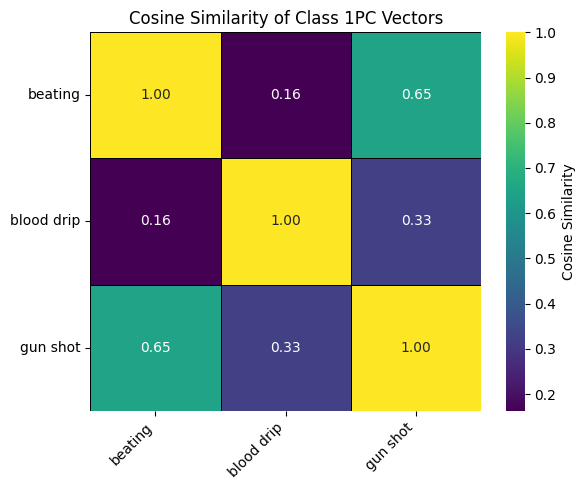

In [74]:
pc_vectors_array = np.array(pc_vectors)
corr_matrix = cosine_similarity(pc_vectors_array)
corr_df = pd.DataFrame(corr_matrix, index=unique_labels, columns=unique_labels)
print("## Correlation Heatmap (Alignment of 1PC Vectors)")

plt.figure(figsize=(6, 5))
sns.heatmap(corr_df, annot=True, cmap="viridis", fmt=".2f", linewidths=.5, linecolor='black', cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity of Class 1PC Vectors")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("correlation_heatmap.png")

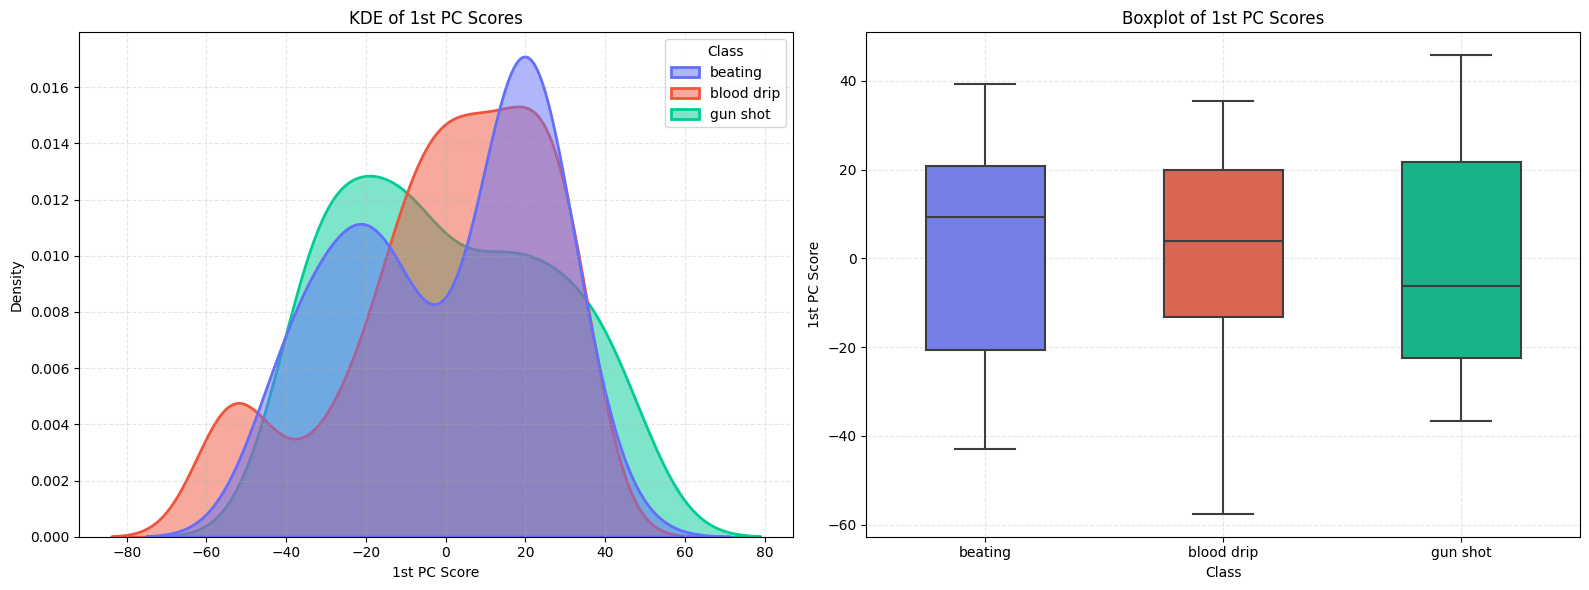

In [44]:
scores_data = []
for label in unique_classes:
    mask = labels == label
    class_data = embeddings[mask]

    pca = PCA(n_components=1)
    pca.fit(class_data)

    class_scores = pca.transform(class_data).flatten()

    for score in class_scores:
        scores_data.append({'Class': label, 'Score': score})

df_scores = pd.DataFrame(scores_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(
    data=df_scores,
    x='Score',
    hue='Class',
    fill=True,
    palette=class_colors,
    ax=axes[0],
    common_norm=False,
    alpha=0.5,
    linewidth=2
)
axes[0].set_title('KDE of 1st PC Scores')
axes[0].set_xlabel('1st PC Score')
axes[0].set_ylabel('Density')
axes[0].grid(True, linestyle='--', alpha=0.3)

sns.boxplot(
    data=df_scores,
    x='Class',
    y='Score',
    hue='Class',
    palette=class_colors,
    ax=axes[1],
    dodge=False,
    width=0.5,
    linewidth=1.5
)
axes[1].set_title('Boxplot of 1st PC Scores')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('1st PC Score')
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].legend([],[], frameon=False)

plt.tight_layout()
plt.show()

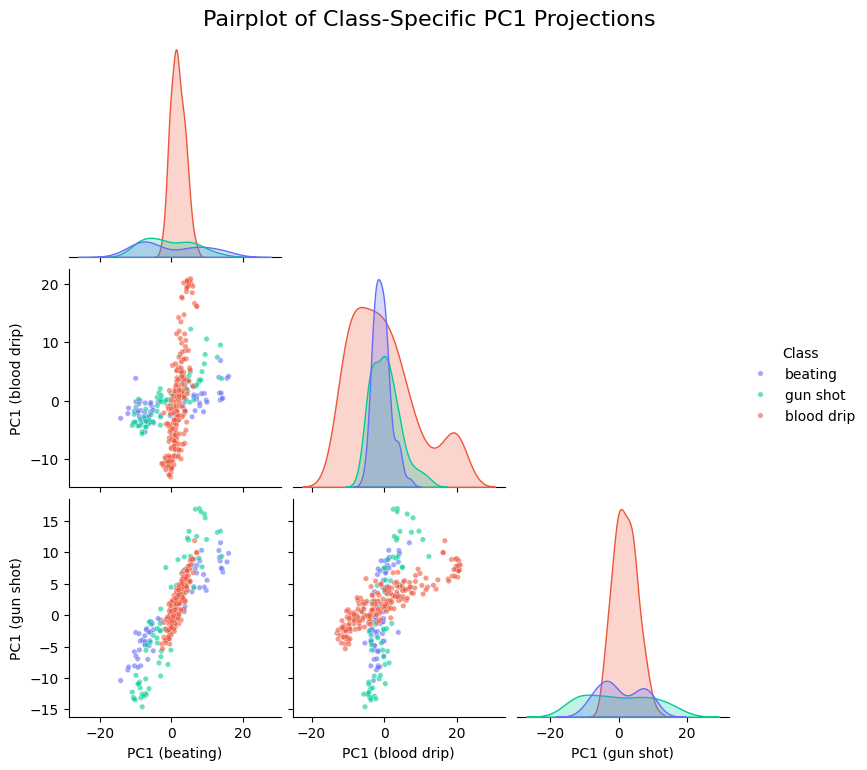

In [45]:
unique_classes = sorted(np.unique(labels))
palette = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']
class_colors = {cls: palette[i % len(palette)] for i, cls in enumerate(unique_classes)}

projections = {}

for cls in unique_classes:
    mask = labels == cls
    local_pca = PCA(n_components=1)
    local_pca.fit(X_scaled[mask])

    projections[f"PC1 ({cls})"] = local_pca.transform(X_scaled).flatten()

df_pair = pd.DataFrame(projections)
df_pair['Class'] = labels

g = sns.pairplot(
    df_pair,
    hue='Class',
    palette=class_colors,
    corner=True,
    kind='scatter',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 15},
    diag_kws={'fill': True}
)

g.fig.suptitle("Pairplot of Class-Specific PC1 Projections", y=1.02, fontsize=16)
plt.show()

# **Data Quality & Hard Samples**

In [56]:
sil_score = silhouette_score(X_scaled, labels)
print(f"Global Silhouette Score: {sil_score:.4f}")
print("-" * 30)

centroids = []

for cls in unique_classes:
    mask = labels == cls
    centroids.append(X_scaled[mask].mean(axis=0))
centroids = np.array(centroids)

dist_matrix = pairwise_distances(centroids)
df_dist = pd.DataFrame(dist_matrix, index=unique_classes, columns=unique_classes)

print("\nDistance Between Class Centroids (Inter-class):")
print(df_dist.round(2))

Global Silhouette Score: 0.1824
------------------------------

Distance Between Class Centroids (Inter-class):
              beating  blood drip  gun shot
beating      0.000000   20.799999      9.80
blood drip  20.799999    0.000000     18.16
gun shot     9.800000   18.160000      0.00


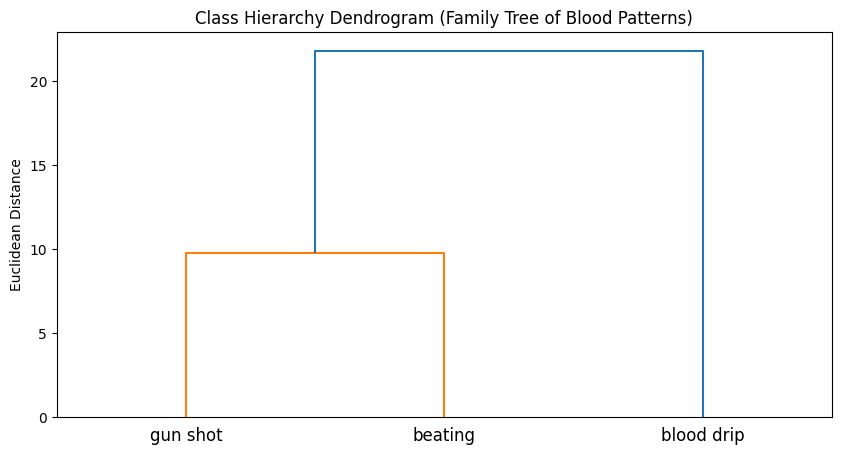

In [77]:
centroids = np.array([X_scaled[labels == cls].mean(axis=0) for cls in unique_classes])

linked = linkage(centroids, 'ward')

plt.figure(figsize=(10, 5))
plt.title('Class Hierarchy Dendrogram (Family Tree of Blood Patterns)')
dendrogram(linked,
           labels=unique_classes,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.ylabel('Euclidean Distance')
plt.show()

# **The Grand Finale**

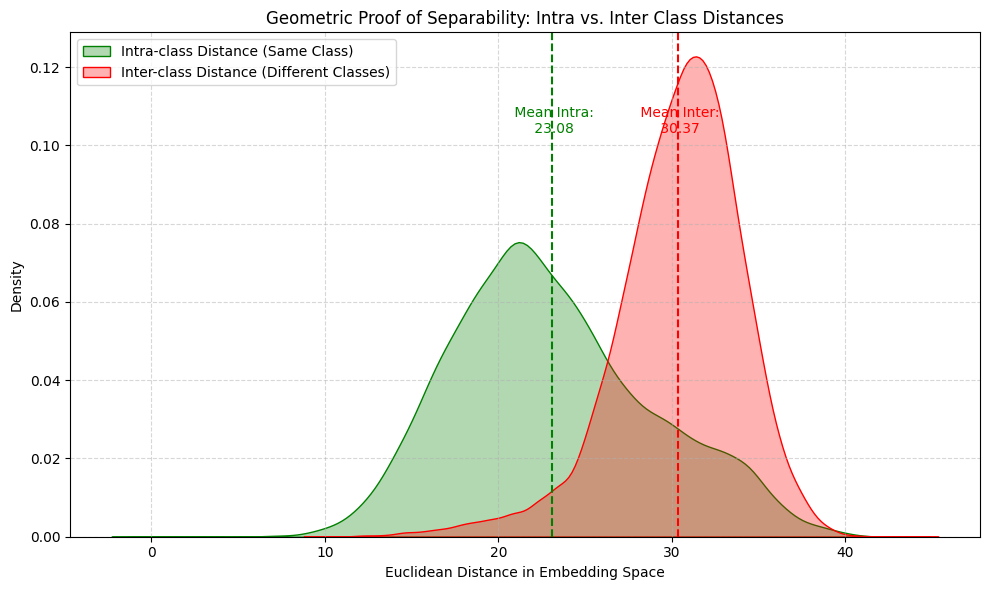

In [78]:
dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))

intra_dists = []
inter_dists = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        d = dist_matrix[i, j]
        if labels[i] == labels[j]:
            intra_dists.append(d)
        else:
            inter_dists.append(d)

plt.figure(figsize=(10, 6))
sns.kdeplot(intra_dists, fill=True, color='green', label='Intra-class Distance (Same Class)', alpha=0.3)
sns.kdeplot(inter_dists, fill=True, color='red', label='Inter-class Distance (Different Classes)', alpha=0.3)

plt.title("Geometric Proof of Separability: Intra vs. Inter Class Distances")
plt.xlabel("Euclidean Distance in Embedding Space")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

mean_intra = np.mean(intra_dists)
mean_inter = np.mean(inter_dists)
plt.axvline(mean_intra, color='green', linestyle='--')
plt.axvline(mean_inter, color='red', linestyle='--')
plt.text(mean_intra, plt.ylim()[1]*0.8, f' Mean Intra:\n {mean_intra:.2f}', color='green', ha='center')
plt.text(mean_inter, plt.ylim()[1]*0.8, f' Mean Inter:\n {mean_inter:.2f}', color='red', ha='center')

plt.tight_layout()
plt.show()

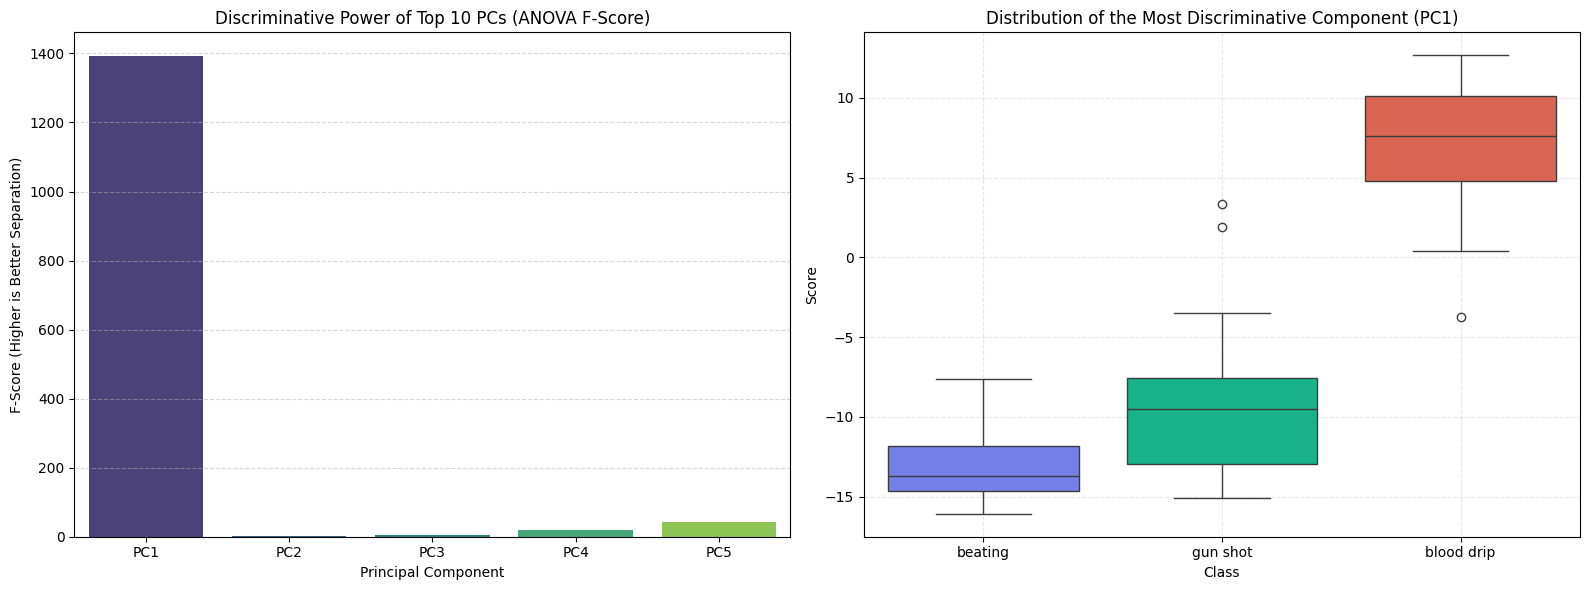

In [81]:
pca_10 = PCA(n_components=5)
X_pca_10 = pca_10.fit_transform(X_scaled)

f_scores = []
for i in range(5):
    pc_data = X_pca_10[:, i]
    groups = [pc_data[labels == cls] for cls in unique_classes]
    f_stat, p_val = f_oneway(*groups)
    f_scores.append(f_stat)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=[f"PC{i+1}" for i in range(5)], y=f_scores, ax=axes[0], palette="viridis")
axes[0].set_title("Discriminative Power of Top 10 PCs (ANOVA F-Score)")
axes[0].set_ylabel("F-Score (Higher is Better Separation)")
axes[0].set_xlabel("Principal Component")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

best_pc_idx = np.argmax(f_scores)
best_pc_name = f"PC{best_pc_idx+1}"

df_best_pc = pd.DataFrame({
    'Score': X_pca_10[:, best_pc_idx],
    'Class': labels
})

sns.boxplot(data=df_best_pc, x='Class', y='Score', hue='Class', palette=class_colors, ax=axes[1], dodge=False)
axes[1].set_title(f"Distribution of the Most Discriminative Component ({best_pc_name})")
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()